In [2]:
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names = ["上衣","褲子","套衫","連衣裙","外套","涼鞋","襯衫","運動鞋","袋子","踝靴"]

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, utils, layers, models, losses, optimizers, metrics
from PIL import Image

seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

In [192]:

def data_downscale(train, test, scale):
    (x_train,y_train) = train
    (x_test,y_test) = test
    num_train = len(x_train) // scale
    num_test = len(x_test) // scale
    x_train, y_train = x_train[:num_train], y_train[:num_train]
    x_test, y_test = x_test[:num_test], y_test[:num_test]
    x_train = x_train.reshape(num_train, (28*28)).astype(np.float32) /255.
    x_test = x_test.reshape(num_test, (28*28)).astype(np.float32) /255.
    return (x_train,y_train), (x_test,y_test)

def mnist_dataset():
    (x_train,y_train),(x_test,y_test) = datasets.fashion_mnist.load_data()
    (x_train,y_train),(x_test,y_test) = data_downscale((x_train,y_train),(x_test,y_test), 10)
    print(x_train.shape, y_train.shape)
    print(x_test.shape, y_test.shape)
    
    return (x_train,y_train), (x_test,y_test)

(x_train,y_train), (x_test,y_test) = mnist_dataset()

(6000, 784) (6000,)
(1000, 784) (1000,)


In [193]:
del VAE
class VAE(models.Model):
    def __init__(self, image_size):
        super(VAE, self).__init__()
        
        self.fc1 = layers.Dense(units=image_size//2, activation="relu", name="fc1")
        self.fc2 = layers.Dense(units=image_size//40, name="fc2")
        self.fc3 = layers.Dense(units=image_size//40, name="fc3")
        self.fc4 = layers.Dense(units=image_size//2, activation="relu", name="fc4")
        self.fc5 = layers.Dense(units=image_size, name="fc5")
        
    def encode(self, x):
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = tf.exp(log_var * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps * std
    
    def decode_logits(self, z):
        h = self.fc4(z)
        return self.fc5(h)        
    
    def call(self, inputs, training=None, mask=None):
        # encode
        mu, log_var = self.encode(inputs) # fc1, fc2, fc3
        #sample
        z = self.reparameterize(mu, log_var) 
        # decode
        x_reconstructed_logits = self.decode_logits(z) # fc4, fc5
        return x_reconstructed_logits, mu, log_var
image_size = 28*28
batch_size = 128
model = VAE(image_size)
model.build(input_shape=(batch_size,784))
model.summary()
optimizer = optimizers.Adam(0.01)

Model: "vae_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  multiple                  307720    
_________________________________________________________________
fc2 (Dense)                  multiple                  7467      
_________________________________________________________________
fc3 (Dense)                  multiple                  7467      
_________________________________________________________________
fc4 (Dense)                  multiple                  7840      
_________________________________________________________________
fc5 (Dense)                  multiple                  308112    
Total params: 638,606
Trainable params: 638,606
Non-trainable params: 0
_________________________________________________________________


In [194]:
#del dataset

num_batches = x_train.shape[0] // batch_size ## 6000 / 128 -> 46  
dataset = tf.data.Dataset.from_tensor_slices(x_train) ## dataset shape 6000 * (784,)
dataset = dataset.shuffle(x_train.shape[0]).batch(batch_size) ## dataset shape (num_batches, batch_size, image_size)
## dataset -> 46 (128,784) + 1 * (112,784)

In [195]:
num_epochs = 3
for epoch in range(3):
    for step, x in enumerate(dataset): ## dataset shape 46 *(128,784) + 1 * (112,784)
        ## step 0~46
        with tf.GradientTape() as tape:
            x_reconstruction_logits, mu, log_var = model(x)            
            reconstruction_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=x_reconstruction_logits)
            reconstruction_loss = tf.reduce_sum(reconstruction_loss) / batch_size
            # please refer to
            # https://stats.stackexchange.com/questions/7440/kl-divergence-between-two-univariate-gaussians
            kl_div = - 0.5 * tf.reduce_sum(1. + log_var - tf.square(mu) - tf.exp(log_var), axis=-1)
            kl_div = tf.reduce_mean(kl_div)
            
            # Backprop and optimize
            loss = tf.reduce_mean(reconstruction_loss) + kl_div
            
        gradients = tape.gradient(loss, model.trainable_variables)
        for g in gradients:
            tf.clip_by_norm(g, 15) ## 梯度進行裁剪，通過控制梯度的最大正規化，防止梯度爆炸的問題，是一種比較常用的梯度規約的方式
        
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if (step + 1) % 10 == 0:
            print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                  .format(epoch + 1, num_epochs, step + 1, num_batches, float(reconstruction_loss), float(kl_div)))

print("finish training")

Epoch[1/3], Step [10/46], Reconst Loss: 427.0248, KL Div: 187.4688
Epoch[1/3], Step [20/46], Reconst Loss: 419.3597, KL Div: 352.3430
Epoch[1/3], Step [30/46], Reconst Loss: 411.7711, KL Div: 437.2648
Epoch[1/3], Step [40/46], Reconst Loss: 374.7649, KL Div: 202.3805
Epoch[2/3], Step [10/46], Reconst Loss: 340.0778, KL Div: 121.2912
Epoch[2/3], Step [20/46], Reconst Loss: 324.3834, KL Div: 128.6599
Epoch[2/3], Step [30/46], Reconst Loss: 309.9944, KL Div: 129.0783
Epoch[2/3], Step [40/46], Reconst Loss: 292.2252, KL Div: 114.4850
Epoch[3/3], Step [10/46], Reconst Loss: 302.4803, KL Div: 118.4011
Epoch[3/3], Step [20/46], Reconst Loss: 294.0965, KL Div: 95.1751
Epoch[3/3], Step [30/46], Reconst Loss: 293.9720, KL Div: 56.3772
Epoch[3/3], Step [40/46], Reconst Loss: 293.3074, KL Div: 59.4258
finish training


VAE


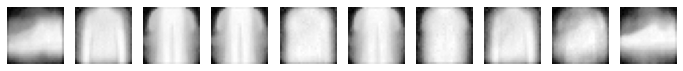

Origin


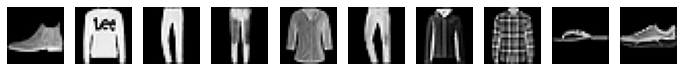

In [198]:
print("VAE")
img, _,a = model(x_test[0:10])
img = np.reshape(img, (10,28,28))
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(img[i], cmap="gray")
plt.show()
print("Origin")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(x_test[i].reshape(28,28), cmap="gray")
plt.show()

VAE


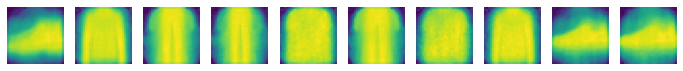

Origin


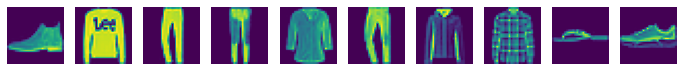

In [199]:
print("VAE")
img, _,a = model(x_test[0:10])
img = np.reshape(img, (10,28,28))
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(img[i])
plt.show()
print("Origin")
plt.figure(figsize=(12,3))
for i in range(10):
    plt.subplot(1,10,(i+1))
    plt.axis("off")
    plt.imshow(x_test[i].reshape(28,28))
plt.show()